# The purpose of this notebook is to display the following:
1. Comparison across loss metrics / loss functions. 
2. Look at a model trained on a small percentage of the data, and view the same models applied to a larger holdout set, and the broader dataset in general.
3. Identify max depth importance for `RandomForestRegressor`. 
4. Provide a platform to view different cross validation techniques
5. Identify feature importance for `RandomForestRegressor`

In [1]:
# General helpful inputs 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
#  Regressors
from sklearn.ensemble import RandomForestRegressor as rfr





# Loss Metrics / Loss Functions
from sklearn.metrics import ( mean_absolute_error,
                             mean_squared_error,
                             r2_score,
                             median_absolute_error)


from sklearn.model_selection import (train_test_split, 
                                     TimeSeriesSplit,
                                     KFold, 
                                     StratifiedKFold, 
                                     GroupKFold,
                                     StratifiedGroupKFold,
                                    )

# Random State
random_state = 82122

# pandas option
pd.set_option('display.max_columns',500)

%matplotlib inline

Read in the data that is ready for modeling. 

There are two columns that could be useful to predict which are both good candidates for regression (`growth_percent_math_19` and `growth_percent_read_19`). There are also a few columns that could be used for classification (`growth_cat_math_19` and `growth_cat_read_19`) 

In [2]:
raw = pd.read_csv('../data/01_raw/Houston_all.csv')
df = raw.copy()

There are a number of features in the dataset that could have importance. The following cell creates a list of each feature within the dataset in order to quickly parse the dataframe based on what is needed as features for our prediction. 

In [3]:
math_target = ['growth_percent_math_19']
read_target = ['growth_percent_read_19']
features = ['Course_2017',
            'Section_2017',
            'Name_2017',
            'TNUM_2017',
            'GR_2017',
            'School_2017',
            'District_2017',
            'GlimpsestudentId',
            'nweaMathPostBenchmarks_2017',
            'nweaReadingPostBenchmarks_2017',
            'nweaMathPost_2017',
            'nweaReadingPost_2017',
            'MathMilestonesPost_2017',
            'ELAMilestonesPost_2017',
            'Course_2018',
            'Section_2018',
            'Name_2018',
            'TNUM_2018',
            'GR_2018',
            'School_2018',
            'District_2018',
            'nweaMathPostBenchmarks_2018',
            'nweaReadingPostBenchmarks_2018',
            'NweaMathPost_2018',
            'NweaReadingPost_2018',
            'MathMilestonesPost_2018',
            'ELAMilestonesPost_2018',
            'Course_2019',
            'Section_2019',
            'Name_2019',
            'TNUM_2019',
            'GR_2019',
            'Year_2019',
            'School_2019',
            'District_2019',
            'nweaMathPreBenchmark_2019',
            'nweaReadingPreBenchmark_2019',
            'nweaMathMidBenchmark_2019',
            'nweaReadingMidBenchmark_2019',
            'nweaMathPre_2019',
            'nweaReadingPre_2019',
            'nweaMathMid_2019',
            'nweaReadingMid_2019',
            'Math_Post2018_to_Pre2019',
            'Reading_Post2018_to_Pre2019',
            'growth_percent_math_1718',
            'growth_percent_read_1718',
            'growth_percent_math_1819',
            'growth_percent_read_1819',
            'growth_cat_math_1718',
            'growth_cat_math_1819',
            'growth_cat_read_1819',
            'growth_cat_read_1718']

One of the primary purposes of this notebook is to display different loss metrics/loss functions, and view these fore each max depth with our `RandomForestRegressor`. We first split our data into 5k rows for quick model building. We then engaged in the following;
1. Sampled the smaller dataset with a percentage of the data (20%)
2. Stored the indices for those samples
3. Segment the dataset into a training and holdout dataset for training, testing, and validating the model


In [4]:
df = df.sample(5000)
# get the index of 20% of rows within the dataset (.2 *5000=1,000)
holdout_ids = df.sample(n=int(len(df)*.20), random_state=random_state).index 
# isolate a training set
training = (df.loc[~df.index.isin(holdout_ids)]
            .sample(frac=1,random_state=random_state)
            .reset_index(drop=True))
# isolate a holdout set 
holdouts = (df.loc[df.index.isin(holdout_ids)]
           .sample(frac=1,random_state=random_state)
           .reset_index(drop=True))

`X` and `y` data were generated using the lists. The values for `y` were then flattened for the input array using `.ravel()`. This process was reapeated for the holdout set as well. 

In [5]:
X = training[features]
y = training[math_target]
y_reshape = y.values.ravel() # Flatten the input array 
X_holdout = holdouts[features]
y_holdout = holdouts[math_target]
y_holdout_reshape = y_holdout.values.ravel() #Flatten the input array 

Generating a `RandomForestRegressor` was used with different `max_depth`'s. 
- `max_depth`: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- `MAE` - MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight.
- `MSE` - is difference between of the estimated values and what you get as a result. The predicted value is based on some equation and tell what you will expect as an average but the result you get might differ from this prediction which is a slight error from the estimated value.
- `RMSE` - RMSE is a quadratic scoring rule that also measures the average magnitude of the error. It’s the square root of the average of squared differences between prediction and actual observation.
- $r^{2}$ - R-squared values range from 0 to 1 and are commonly stated as percentages from 0% to 100%. An R-squared of 100% means that all movements of a security (or another dependent variable) are completely explained by movements in the index (or the independent variable(s) you are interested in)
- `median_absolute_error` Median absolute error regression loss. Median absolute error output is non-negative floating point. The best value is 0.0.




In [6]:
data = []
x_pred_dfs = []
hold_out_dfs = []
predict_all = []
model_dct = {}
for i in range(2,10,1):
    random_forest_regressor = rfr(max_depth=i,random_state=random_state)
    random_forest_regressor.fit(X,y_reshape)
    model_dct[f'random_forest_regressor_{i}'] = random_forest_regressor
    prediction = random_forest_regressor.predict(X)
    holdout_prediction = random_forest_regressor.predict(X_holdout)
    hold_out_dfs.append(pd.DataFrame({f'holdout_prediction_max_depth_0{i}':holdout_prediction}))
    x_pred_dfs.append(pd.DataFrame({f'pred_x_max_depth_{i}':prediction}))
    #holdout_prediction = random_forest_regressor.predict()
    data.append({'MAE': mean_absolute_error(y,prediction),
                'MSE' : mean_squared_error(y,prediction),
                'R2' :r2_score(y,prediction),
                'median_absolute_error' : median_absolute_error(y,prediction),
                'max_depth':i,
                'MAE_holdout': mean_absolute_error(y_holdout,holdout_prediction),
                'MSE_holdout' : mean_squared_error(y_holdout,holdout_prediction),
                'R2_holdout' :r2_score(y_holdout,holdout_prediction),
                'median_absolute_error_holdout' : median_absolute_error(y_holdout,holdout_prediction)})
    

There are two graphs for each of the predictions made on the holdout dataset. The left are the holdout actual values vs. the holdout predicted values. 

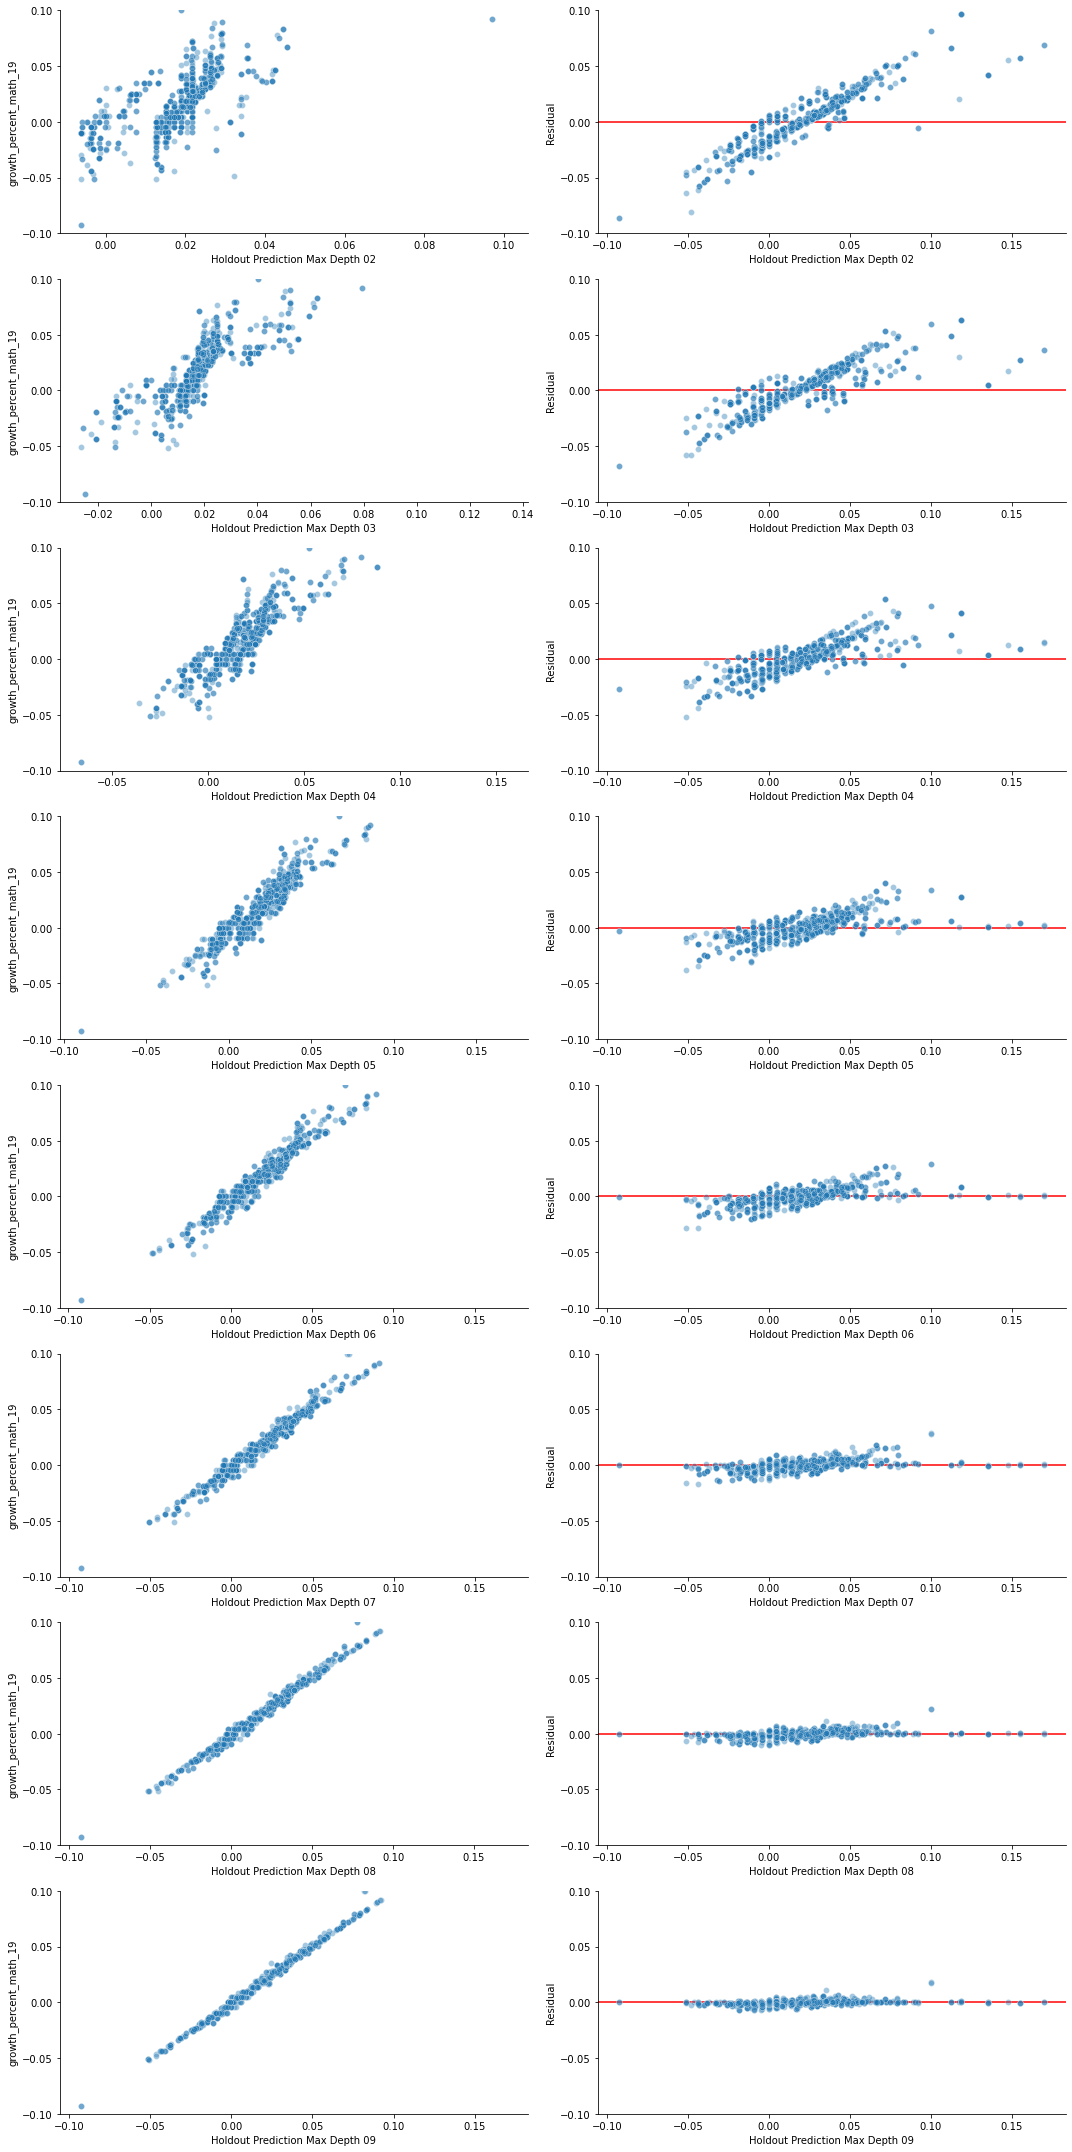

In [7]:
fig, ax = plt.subplots(ncols=2,nrows=8,figsize=(15,30))
ax = ax.flatten()
hold_out_pred_df = pd.concat(hold_out_dfs,axis=1)
x_pred_df = pd.concat(x_pred_dfs,axis=1)
counter = 0

for indx,val in enumerate(sorted(list(hold_out_pred_df)*2)):
    if counter % 2 == 0:
        sns.scatterplot(y=y_holdout['growth_percent_math_19'],x= hold_out_pred_df.loc[:,val],ax=ax[indx],alpha=.4,zorder=1) 
        ax[indx].set_ylim([-.1,.1])
        sns.despine(top=True,right=True)
        ax[indx].locator_params(axis='y', nbins=5)
        ax[indx].set_xlabel(' '.join(val.split('_')).title())
    else:
        sns.scatterplot(x=y_holdout['growth_percent_math_19'],y=y_holdout['growth_percent_math_19']- hold_out_pred_df.loc[:,val],ax=ax[indx],alpha=.4,zorder=1) 
        ax[indx].axhline(0,color='red',zorder=0)
        ax[indx].set_ylim([-.1,.1])
        sns.despine(top=True,right=True)
        ax[indx].set_ylabel('Residual')
        ax[indx].locator_params(axis='y', nbins=5)
        ax[indx].set_xlabel(' '.join(val.split('_')).title())
    counter += 1

plt.tight_layout()
plt.show()
    

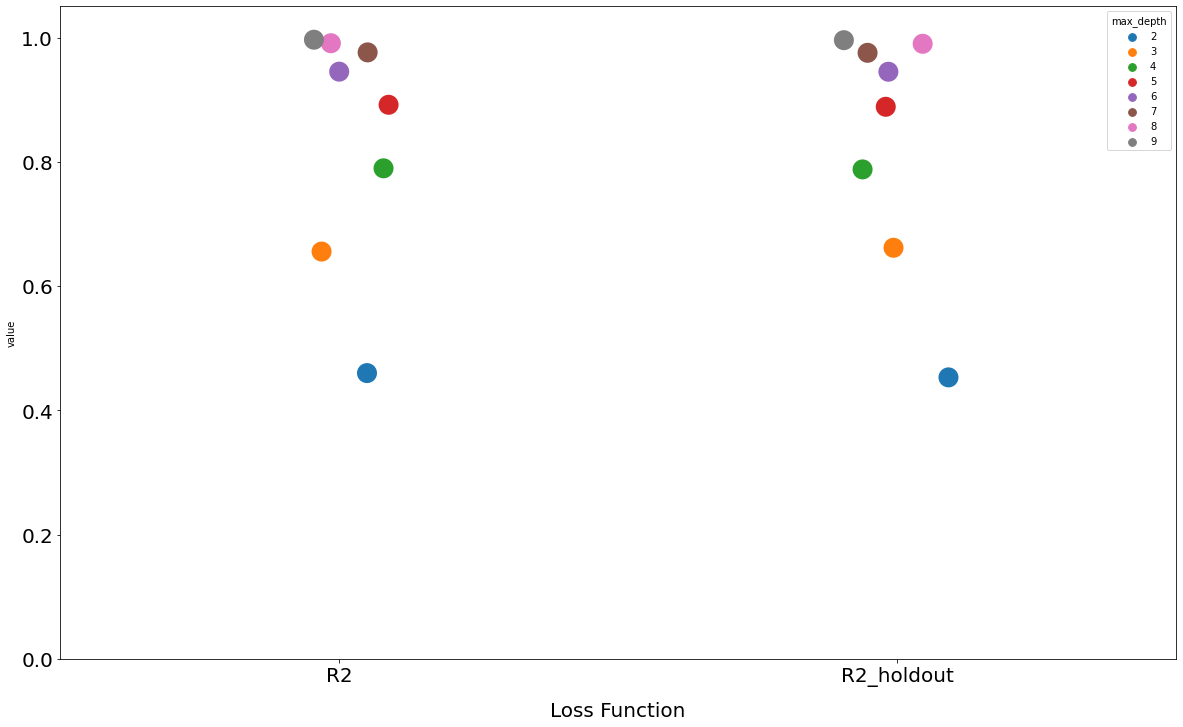

In [8]:
loss = pd.DataFrame(data)
long_loss = pd.melt(loss,id_vars=['max_depth'])
fig, ax = plt.subplots(figsize=(20,12))
sns.stripplot(data=long_loss[long_loss['variable'].isin(['R2','R2_holdout'])].reset_index(drop=True),x='variable',y='value',hue='max_depth',size=20)
ax.set_ylim([0,1.05])
plt.xticks(fontsize=20)
plt.xlabel('Loss Function',fontsize=20,labelpad=15)
plt.yticks(fontsize=20)
plt.show()

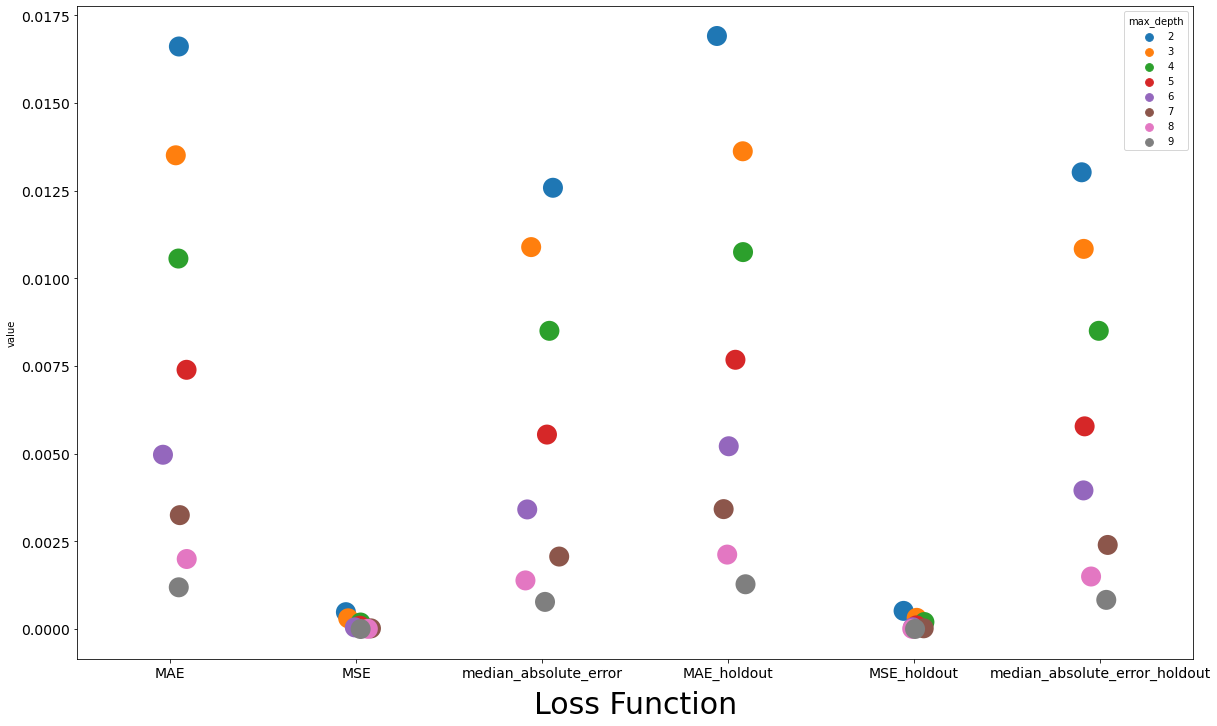

In [9]:
fig, ax = plt.subplots(figsize=(20,12))
sns.stripplot(data=long_loss.loc[~long_loss['variable'].isin(['R2','R2_holdout']),:].reset_index(drop=True),x='variable',y='value',hue='max_depth',size=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Loss Function',fontsize=30,labelpad=10)
plt.show()

In [10]:
all_y = raw[math_target]
all_x = raw[features]

In [11]:
all_data_prediction = []
data = []
count = 2
for model_name,model in model_dct.items():
    print(model_name)
    prediction = model.predict(all_x)
    all_data_prediction.append(pd.DataFrame({f'{model_name}':prediction}))
    data.append({'MAE': mean_absolute_error(all_y,prediction),
                'MSE' : mean_squared_error(all_y,prediction),
                'R2' :r2_score(all_y,prediction),
                'median_absolute_error' : median_absolute_error(all_y,prediction),
                 'max_depth':count})
    count +=1
df = pd.concat(all_data_prediction,axis=1)
df

random_forest_regressor_2
random_forest_regressor_3
random_forest_regressor_4
random_forest_regressor_5
random_forest_regressor_6
random_forest_regressor_7
random_forest_regressor_8
random_forest_regressor_9


,random_forest_regressor_2,random_forest_regressor_3,random_forest_regressor_4,random_forest_regressor_5,random_forest_regressor_6,random_forest_regressor_7,random_forest_regressor_8,random_forest_regressor_9
0,0.016990,0.015034,0.011982,0.006962,0.011225,0.014155,0.014528,0.014099
1,0.016990,0.015034,0.011982,0.006962,0.011225,0.014155,0.014528,0.014099
2,0.016990,0.015034,0.011982,0.006962,0.011225,0.014155,0.014528,0.014099
3,0.016990,0.015034,0.011982,0.006962,0.011225,0.014155,0.014528,0.014099
4,0.016990,0.015034,0.011982,0.006962,0.011225,0.014155,0.014528,0.014099
...,...,...,...,...,...,...,...,...
424642,0.015028,0.012990,0.010674,0.005450,0.009637,0.012310,0.012093,0.011808
424643,0.015028,0.012990,0.010674,0.005450,0.009637,0.012310,0.012093,0.011808
424644,0.015028,0.012990,0.010674,0.005450,0.009637,0.012310,0.012093,0.011808
424645,0.015028,0.012990,0.010674,0.005450,0.009637,0.012310,0.012093,0.011808


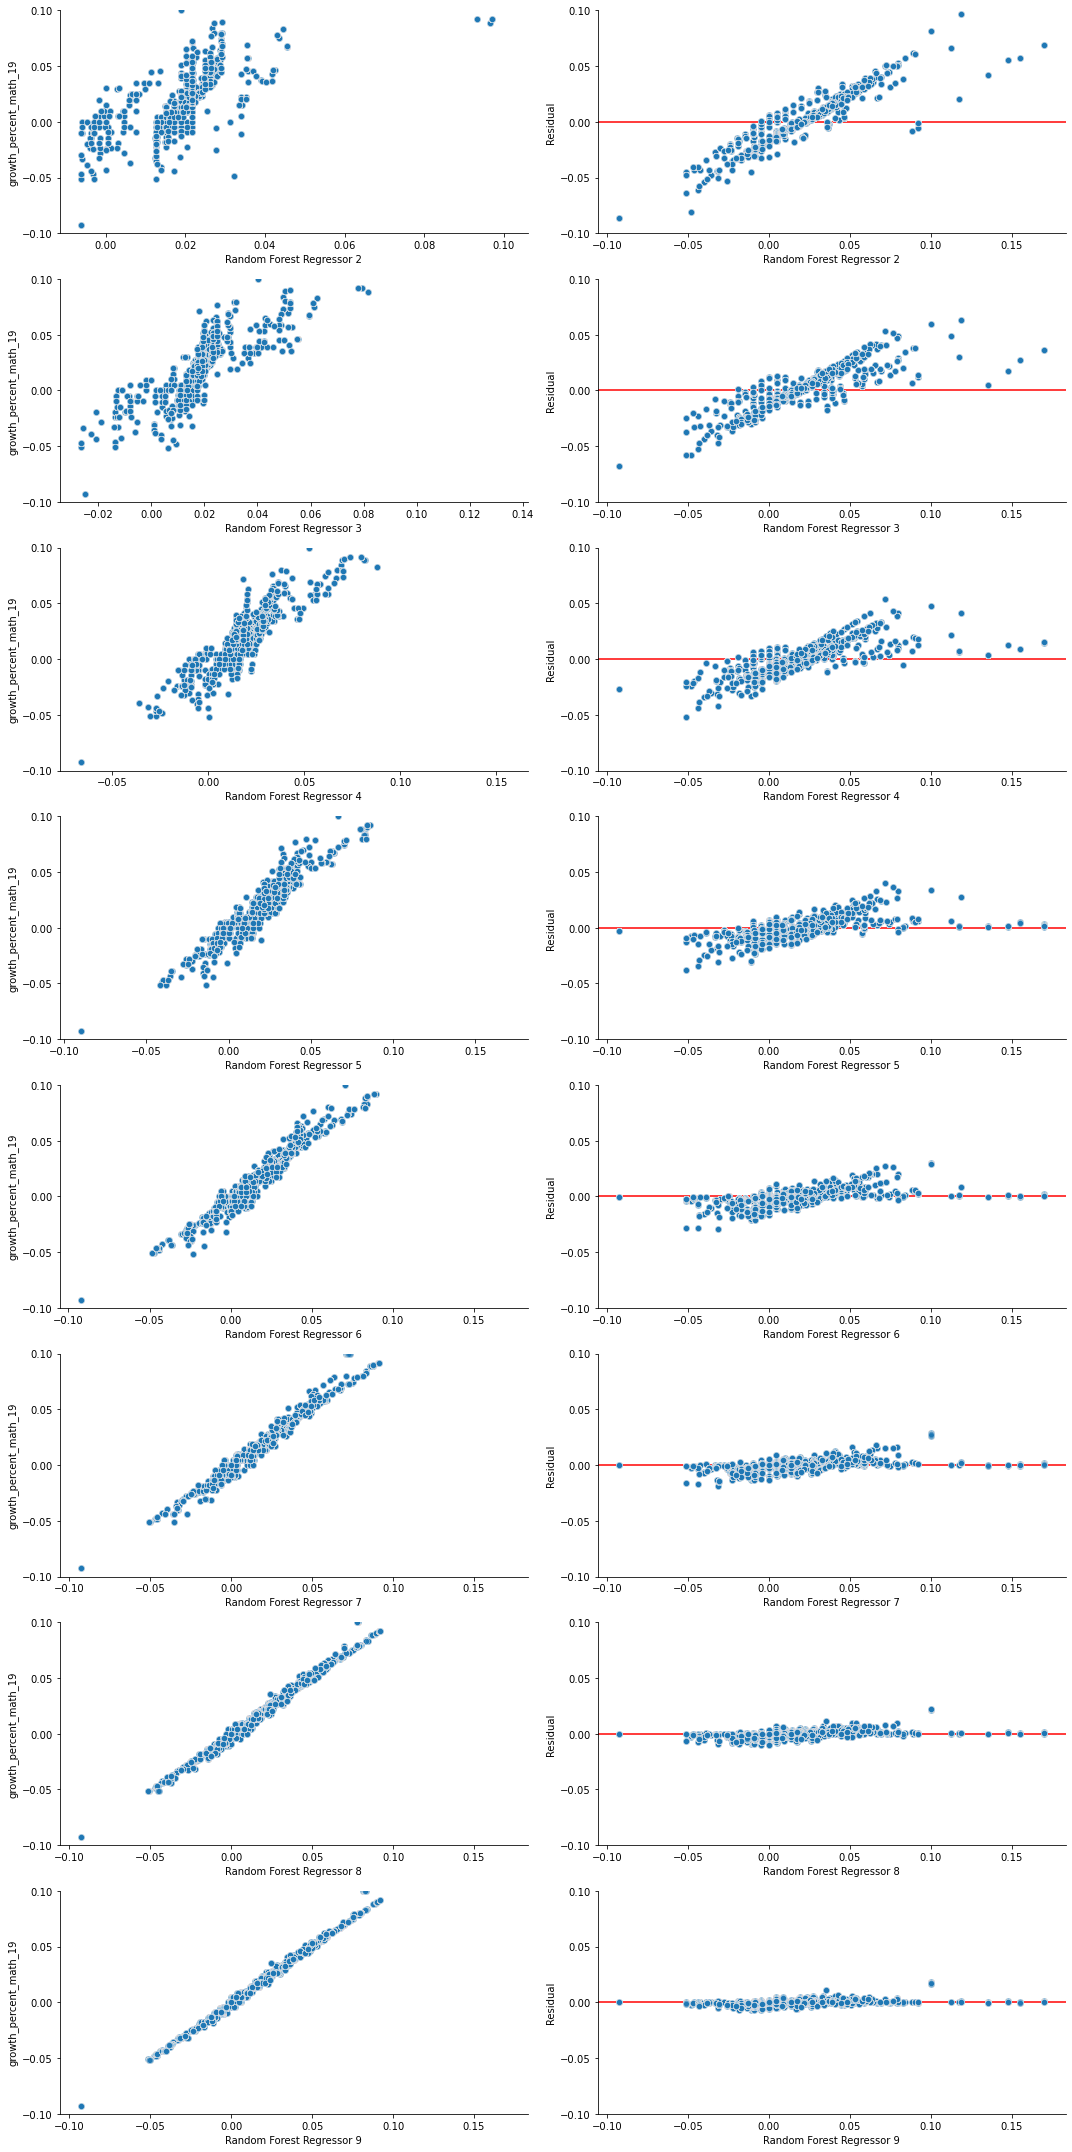

In [12]:
fig, ax = plt.subplots(ncols=2,nrows=8,figsize=(15,30))
ax = ax.flatten()


counter = 0
for indx,val in enumerate(sorted(list(df)*2)):
    if counter % 2 == 0:
        sns.scatterplot(y=all_y['growth_percent_math_19'],x= df.loc[:,val],ax=ax[indx],alpha=.4,zorder=1) 
        ax[indx].set_ylim([-.1,.1])
        sns.despine(top=True,right=True)
        ax[indx].locator_params(axis='y', nbins=5)
        ax[indx].set_xlabel(' '.join(val.split('_')).title())
    else:
        sns.scatterplot(x=all_y['growth_percent_math_19'],y=all_y['growth_percent_math_19']- df.loc[:,val],ax=ax[indx],alpha=.4,zorder=1) 
        ax[indx].axhline(0,color='red',zorder=0)
        ax[indx].set_ylim([-.1,.1])
        sns.despine(top=True,right=True)
        ax[indx].locator_params(axis='y', nbins=5)
        ax[indx].set_ylabel('Residual')
        ax[indx].set_xlabel(' '.join(val.split('_')).title())
    counter += 1

plt.tight_layout()
plt.show()

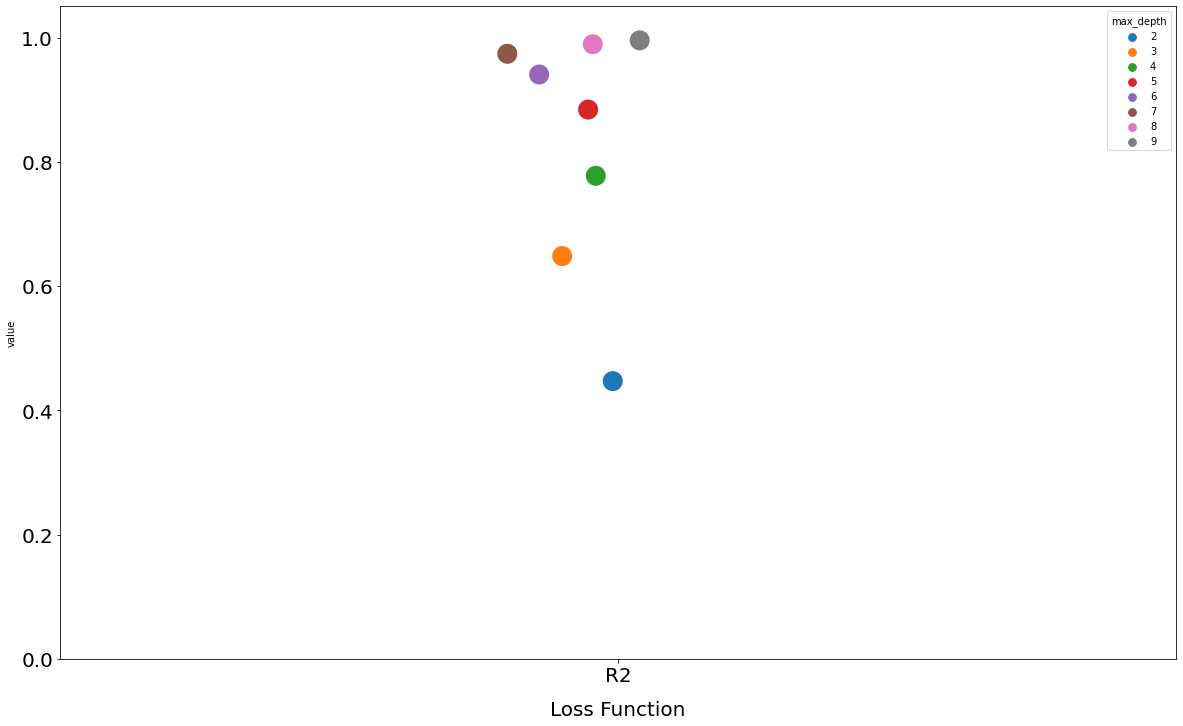

In [13]:
loss = pd.DataFrame(data)
long_loss = pd.melt(loss,id_vars=['max_depth'])
fig, ax = plt.subplots(figsize=(20,12))
sns.stripplot(data=long_loss[long_loss['variable'].isin(['R2','R2_holdout'])].reset_index(drop=True),x='variable',y='value',hue='max_depth',size=20)
ax.set_ylim([0,1.05])
plt.xticks(fontsize=20)
plt.xlabel('Loss Function',fontsize=20,labelpad=15)
plt.yticks(fontsize=20)
plt.show()

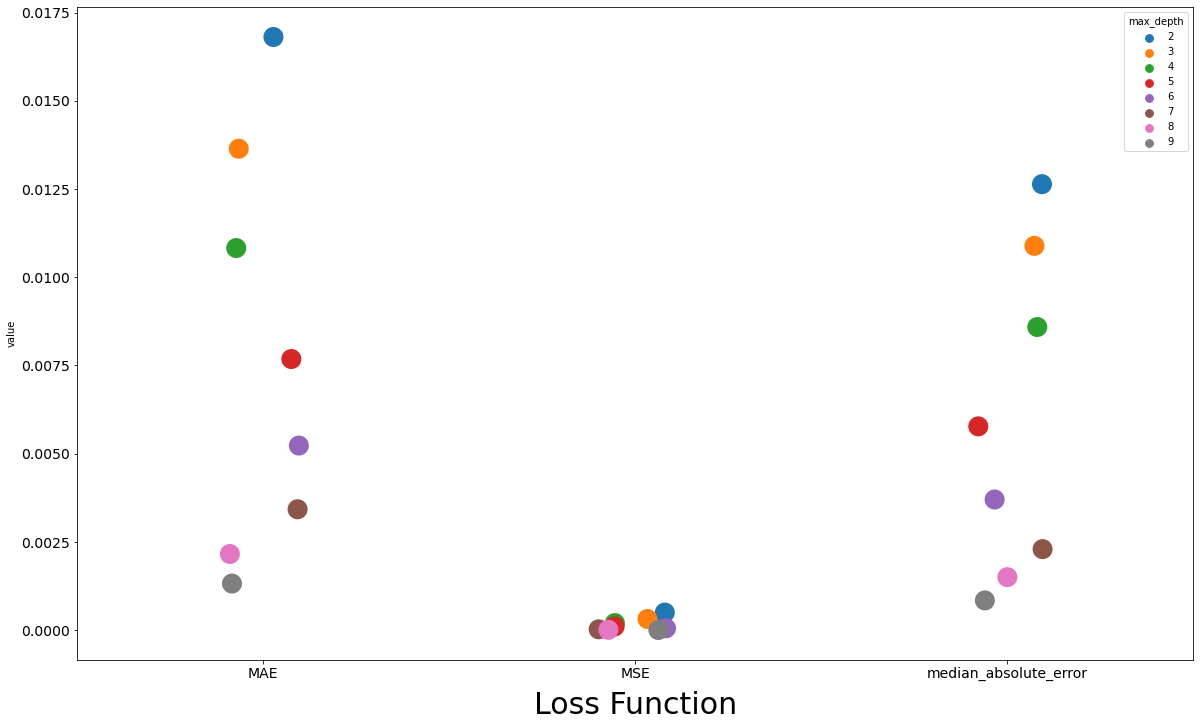

In [14]:
fig, ax = plt.subplots(figsize=(20,12))
sns.stripplot(data=long_loss.loc[~long_loss['variable'].isin(['R2','R2_holdout']),:].reset_index(drop=True),x='variable',y='value',hue='max_depth',size=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Loss Function',fontsize=30,labelpad=10)
plt.show()

<AxesSubplot:>

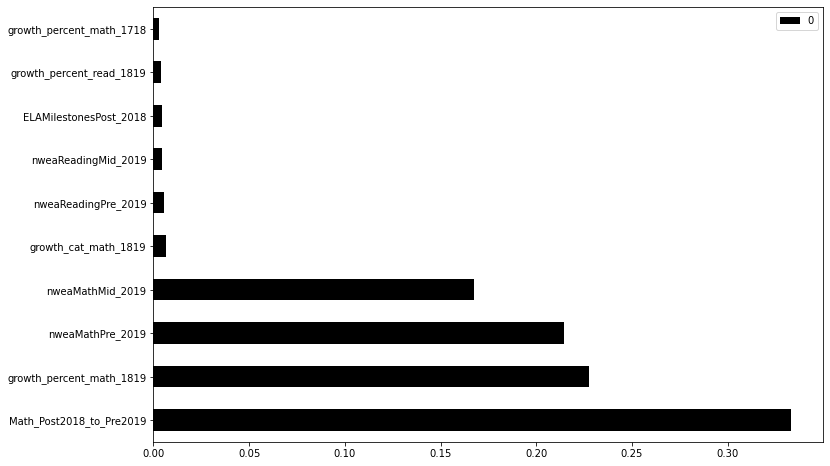

In [16]:
feature_importance = pd.DataFrame(model.feature_importances_,index=X.columns.tolist())
fig, ax = plt.subplots(figsize=(12,8))
feature_importance.sort_values(by=0,ascending=False).head(10).plot(kind='barh',ax=ax,color='black')

In [ ]:
# Start cross validation